In [1]:
%matplotlib inline

import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from sklearn.model_selection import train_test_split

# https://discuss.pytorch.org/t/output-of-resnet34-network-depends-on-the-batch-size/21647
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
np.random.seed(0)

In [2]:
n_epocs = 10000
epochs_per_stats = 1
batch_size = 4096
test_size = 0.2
learning_rate = 0.002 * (batch_size / 1024.0)
momentum = 0.0

WORKING_DIR = '/home/richard/Downloads/nn/PSU_back/'

In [3]:
boards = torch.load('/home/richard/Downloads/connect4_boards.pth').numpy()
values = torch.load('/home/richard/Downloads/connect4_values.pth').numpy()

# Here we don't want to have the player to move channel
boards = boards[:, 1:]

board_train, board_test, value_train, value_test = train_test_split(boards, values, test_size=test_size, shuffle=True)

In [4]:
from connect4.neural.nn_pytorch import Connect4Dataset

train = Connect4Dataset(board_train, value_train)
test = Connect4Dataset(board_test, value_test)

train_gen = data.DataLoader(train, batch_size, shuffle=True)
test_gen = data.DataLoader(test, 4096, shuffle=False)
# test_gen = data.DataLoader(test, batch_size, shuffle=False)

In [5]:
from connect4.neural.nn_pytorch import build_value_net

net = build_value_net(64, value_head_fc_layers=16)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.0000001)
    elif type(m) == nn.Conv2d:
        nn.init.normal_(m.weight, std=0.0000001)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, std=0.0000001)
#         nn.init.constant_(m.bias, 0)

# net.apply(init_normal)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (1): Sequential(
    (0): ResidualLayer(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): ResidualLayer(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0

In [6]:
criterion = nn.MSELoss()
# criterion = nn.L1Loss(reduction='none')

# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(net.parameters())

In [7]:
# option to load previous progress
# file_path = WORKING_DIR + '../nn9.pth'
# file_path = '/home/richard/Downloads/nn/8-1.pth'
file_path = None
if file_path is not None:
    checkpoint = torch.load(file_path)
    net.load_state_dict(checkpoint['net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [8]:
from connect4.neural.stats import Stats

# Get an idea of how the initialisation is
def evaluate_fit(net, test_gen, device, output_stats=False):
    test_stats = Stats() if output_stats else None
    with torch.set_grad_enabled(False):
        net = net.eval()
        net.train(False)
        for board, value in test_gen:
            board, value = board.to(device), value.to(device)

            output = net(board)
            output = output.view(-1)
            assert output.shape == value.shape
            
            loss = criterion(output, value)
#             print(output.shape, value.shape)
#             print(output, value, loss)

            if output_stats:
                output = output.cpu().numpy().flatten()
                value = value.cpu().numpy().flatten()
                test_stats.update(output, value, loss)
    return test_stats

test_stats = evaluate_fit(net, test_gen, device, True)
print("Initial Test Stats:\n", test_stats)

Initial Test Stats:
 Average loss:  0.24114  Accuracy:  0.09458  Smallest:  0.46713  Largest:  0.46713  Average:  0.46713
Category, # Members, # Correct Predictions:  (0.0, 3300, 0)  (0.5, 1278, 1278)  (1.0, 8934, 0)


Epoch:   0 
Train:
 Average loss:  0.21300  Accuracy:  0.09581  Smallest:  0.46712  Largest:  0.67049  Average:  0.54264
Category, # Members, # Correct Predictions:  (0.0, 13335, 0)  (0.5, 5171, 5171)  (1.0, 35539, 7) 
Test:
 Average loss:  0.18376  Accuracy:  0.66119  Smallest:  0.67833  Largest:  0.67918  Average:  0.67867
Category, # Members, # Correct Predictions:  (0.0, 3300, 0)  (0.5, 1278, 0)  (1.0, 8934, 8934)


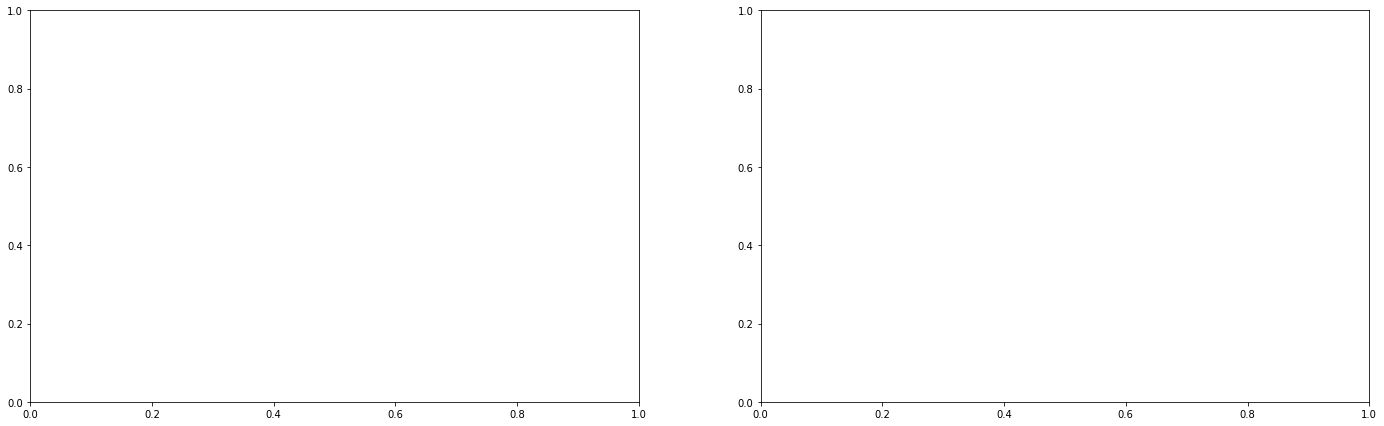

Epoch:   1 
Train:
 Average loss:  0.17103  Accuracy:  0.65758  Smallest:  0.67775  Largest:  0.93207  Average:  0.76127
Category, # Members, # Correct Predictions:  (0.0, 13335, 0)  (0.5, 5171, 0)  (1.0, 35539, 35539) 
Test:
 Average loss:  0.18271  Accuracy:  0.66119  Smallest:  0.67716  Largest:  0.71101  Average:  0.67927
Category, # Members, # Correct Predictions:  (0.0, 3300, 0)  (0.5, 1278, 0)  (1.0, 8934, 8934)
Epoch:   2 
Train:
 Average loss:  0.12314  Accuracy:  0.64169  Smallest:  0.50258  Largest:  0.99958  Average:  0.78839
Category, # Members, # Correct Predictions:  (0.0, 13335, 0)  (0.5, 5171, 2381)  (1.0, 35539, 32299) 
Test:
 Average loss:  0.16578  Accuracy:  0.32201  Smallest:  0.49182  Largest:  0.99614  Average:  0.58696
Category, # Members, # Correct Predictions:  (0.0, 3300, 0)  (0.5, 1278, 1271)  (1.0, 8934, 3080)
Epoch:   3 
Train:
 Average loss:  0.08078  Accuracy:  0.70671  Smallest:  0.05082  Largest:  1.00000  Average:  0.74609
Category, # Members, # Corr

Epoch:   20 
Train:
 Average loss:  0.01894  Accuracy:  0.82026  Smallest:  0.00054  Largest:  1.00000  Average:  0.70716
Category, # Members, # Correct Predictions:  (0.0, 13335, 12711)  (0.5, 5171, 1749)  (1.0, 35539, 29871) 
Test:
 Average loss:  0.05106  Accuracy:  0.78427  Smallest:  0.00075  Largest:  1.00000  Average:  0.69823
Category, # Members, # Correct Predictions:  (0.0, 3300, 2846)  (0.5, 1278, 324)  (1.0, 8934, 7427)
Epoch:   21 
Train:
 Average loss:  0.01690  Accuracy:  0.82685  Smallest:  0.00035  Largest:  1.00000  Average:  0.70793
Category, # Members, # Correct Predictions:  (0.0, 13335, 12782)  (0.5, 5171, 1865)  (1.0, 35539, 30040) 
Test:
 Average loss:  0.06407  Accuracy:  0.79766  Smallest:  0.00058  Largest:  1.00000  Average:  0.64053
Category, # Members, # Correct Predictions:  (0.0, 3300, 3041)  (0.5, 1278, 311)  (1.0, 8934, 7426)
Epoch:   22 
Train:
 Average loss:  0.01869  Accuracy:  0.83231  Smallest:  0.00046  Largest:  1.00000  Average:  0.70726
Catego

Epoch:   39 
Train:
 Average loss:  0.00829  Accuracy:  0.80709  Smallest:  0.00001  Largest:  1.00000  Average:  0.70585
Category, # Members, # Correct Predictions:  (0.0, 13335, 13133)  (0.5, 5171, 3033)  (1.0, 35539, 27453) 
Test:
 Average loss:  0.05526  Accuracy:  0.59384  Smallest:  0.00001  Largest:  1.00000  Average:  0.74754
Category, # Members, # Correct Predictions:  (0.0, 3300, 2563)  (0.5, 1278, 268)  (1.0, 8934, 5193)
Epoch:   40 
Train:
 Average loss:  0.00819  Accuracy:  0.78177  Smallest:  0.00001  Largest:  1.00000  Average:  0.70473
Category, # Members, # Correct Predictions:  (0.0, 13335, 13156)  (0.5, 5171, 3089)  (1.0, 35539, 26006) 
Test:
 Average loss:  0.05253  Accuracy:  0.67192  Smallest:  0.00002  Largest:  1.00000  Average:  0.70455
Category, # Members, # Correct Predictions:  (0.0, 3300, 2785)  (0.5, 1278, 353)  (1.0, 8934, 5941)
Epoch:   41 
Train:
 Average loss:  0.00861  Accuracy:  0.77874  Smallest:  0.00002  Largest:  1.00000  Average:  0.70610
Catego

Epoch:   58 
Train:
 Average loss:  0.00552  Accuracy:  0.72268  Smallest:  0.00000  Largest:  1.00000  Average:  0.70570
Category, # Members, # Correct Predictions:  (0.0, 13335, 13192)  (0.5, 5171, 3871)  (1.0, 35539, 21994) 
Test:
 Average loss:  0.05040  Accuracy:  0.57083  Smallest:  0.00000  Largest:  1.00000  Average:  0.72029
Category, # Members, # Correct Predictions:  (0.0, 3300, 2640)  (0.5, 1278, 479)  (1.0, 8934, 4594)
Epoch:   59 
Train:
 Average loss:  0.00450  Accuracy:  0.69709  Smallest:  0.00000  Largest:  1.00000  Average:  0.70652
Category, # Members, # Correct Predictions:  (0.0, 13335, 13216)  (0.5, 5171, 4130)  (1.0, 35539, 20328) 
Test:
 Average loss:  0.05217  Accuracy:  0.55351  Smallest:  0.00000  Largest:  1.00000  Average:  0.69402
Category, # Members, # Correct Predictions:  (0.0, 3300, 2812)  (0.5, 1278, 456)  (1.0, 8934, 4211)
Epoch:   60 
Train:
 Average loss:  0.00443  Accuracy:  0.67771  Smallest:  0.00000  Largest:  1.00000  Average:  0.70567
Catego

Epoch:   77 
Train:
 Average loss:  0.00433  Accuracy:  0.64089  Smallest:  0.00000  Largest:  1.00000  Average:  0.70643
Category, # Members, # Correct Predictions:  (0.0, 13335, 13188)  (0.5, 5171, 4294)  (1.0, 35539, 17155) 
Test:
 Average loss:  0.05518  Accuracy:  0.43643  Smallest:  0.00000  Largest:  1.00000  Average:  0.75326
Category, # Members, # Correct Predictions:  (0.0, 3300, 2368)  (0.5, 1278, 450)  (1.0, 8934, 3079)
Epoch:   78 
Train:
 Average loss:  0.00428  Accuracy:  0.62137  Smallest:  0.00000  Largest:  1.00000  Average:  0.70732
Category, # Members, # Correct Predictions:  (0.0, 13335, 13198)  (0.5, 5171, 4252)  (1.0, 35539, 16132) 
Test:
 Average loss:  0.05342  Accuracy:  0.52738  Smallest:  0.00000  Largest:  1.00000  Average:  0.68139
Category, # Members, # Correct Predictions:  (0.0, 3300, 2812)  (0.5, 1278, 567)  (1.0, 8934, 3747)
Epoch:   79 
Train:
 Average loss:  0.00512  Accuracy:  0.61676  Smallest:  0.00000  Largest:  1.00000  Average:  0.70599
Catego

Epoch:   96 
Train:
 Average loss:  0.00476  Accuracy:  0.63286  Smallest:  0.00000  Largest:  1.00000  Average:  0.70641
Category, # Members, # Correct Predictions:  (0.0, 13335, 13153)  (0.5, 5171, 4209)  (1.0, 35539, 16841) 
Test:
 Average loss:  0.04970  Accuracy:  0.48949  Smallest:  0.00000  Largest:  1.00000  Average:  0.71238
Category, # Members, # Correct Predictions:  (0.0, 3300, 2676)  (0.5, 1278, 520)  (1.0, 8934, 3418)
Epoch:   97 
Train:
 Average loss:  0.00360  Accuracy:  0.62796  Smallest:  0.00000  Largest:  1.00000  Average:  0.70644
Category, # Members, # Correct Predictions:  (0.0, 13335, 13233)  (0.5, 5171, 4395)  (1.0, 35539, 16310) 
Test:
 Average loss:  0.04946  Accuracy:  0.48912  Smallest:  0.00000  Largest:  1.00000  Average:  0.72327
Category, # Members, # Correct Predictions:  (0.0, 3300, 2576)  (0.5, 1278, 551)  (1.0, 8934, 3482)
Epoch:   98 
Train:
 Average loss:  0.00338  Accuracy:  0.62485  Smallest:  0.00000  Largest:  1.00000  Average:  0.70726
Catego

Epoch:   115 
Train:
 Average loss:  0.00339  Accuracy:  0.59621  Smallest:  0.00000  Largest:  1.00000  Average:  0.70612
Category, # Members, # Correct Predictions:  (0.0, 13335, 13228)  (0.5, 5171, 4528)  (1.0, 35539, 14466) 
Test:
 Average loss:  0.04994  Accuracy:  0.45752  Smallest:  0.00000  Largest:  1.00000  Average:  0.69985
Category, # Members, # Correct Predictions:  (0.0, 3300, 2787)  (0.5, 1278, 540)  (1.0, 8934, 2855)
Epoch:   116 
Train:
 Average loss:  0.00312  Accuracy:  0.60067  Smallest:  0.00000  Largest:  1.00000  Average:  0.70616
Category, # Members, # Correct Predictions:  (0.0, 13335, 13261)  (0.5, 5171, 4512)  (1.0, 35539, 14690) 
Test:
 Average loss:  0.05390  Accuracy:  0.41881  Smallest:  0.00000  Largest:  1.00000  Average:  0.75083
Category, # Members, # Correct Predictions:  (0.0, 3300, 2355)  (0.5, 1278, 519)  (1.0, 8934, 2785)
Epoch:   117 
Train:
 Average loss:  0.00347  Accuracy:  0.59935  Smallest:  0.00000  Largest:  1.00000  Average:  0.70649
Cat

Epoch:   134 
Train:
 Average loss:  0.00286  Accuracy:  0.59809  Smallest:  0.00000  Largest:  1.00000  Average:  0.70604
Category, # Members, # Correct Predictions:  (0.0, 13335, 13262)  (0.5, 5171, 4612)  (1.0, 35539, 14450) 
Test:
 Average loss:  0.05283  Accuracy:  0.46544  Smallest:  0.00000  Largest:  1.00000  Average:  0.68737
Category, # Members, # Correct Predictions:  (0.0, 3300, 2798)  (0.5, 1278, 585)  (1.0, 8934, 2906)
Epoch:   135 
Train:
 Average loss:  0.00271  Accuracy:  0.60263  Smallest:  0.00000  Largest:  1.00000  Average:  0.70603
Category, # Members, # Correct Predictions:  (0.0, 13335, 13243)  (0.5, 5171, 4671)  (1.0, 35539, 14655) 
Test:
 Average loss:  0.05028  Accuracy:  0.47054  Smallest:  0.00000  Largest:  1.00000  Average:  0.70501
Category, # Members, # Correct Predictions:  (0.0, 3300, 2659)  (0.5, 1278, 601)  (1.0, 8934, 3098)
Epoch:   136 
Train:
 Average loss:  0.00258  Accuracy:  0.58605  Smallest:  0.00000  Largest:  1.00000  Average:  0.70632
Cat

Epoch:   153 
Train:
 Average loss:  0.00314  Accuracy:  0.56031  Smallest:  0.00000  Largest:  1.00000  Average:  0.70618
Category, # Members, # Correct Predictions:  (0.0, 13335, 13254)  (0.5, 5171, 4547)  (1.0, 35539, 12481) 
Test:
 Average loss:  0.05624  Accuracy:  0.46048  Smallest:  0.00000  Largest:  1.00000  Average:  0.66835
Category, # Members, # Correct Predictions:  (0.0, 3300, 2903)  (0.5, 1278, 595)  (1.0, 8934, 2724)
Epoch:   154 
Train:
 Average loss:  0.00292  Accuracy:  0.56240  Smallest:  0.00000  Largest:  1.00000  Average:  0.70640
Category, # Members, # Correct Predictions:  (0.0, 13335, 13241)  (0.5, 5171, 4611)  (1.0, 35539, 12543) 
Test:
 Average loss:  0.05416  Accuracy:  0.34954  Smallest:  0.00000  Largest:  1.00000  Average:  0.74793
Category, # Members, # Correct Predictions:  (0.0, 3300, 2428)  (0.5, 1278, 485)  (1.0, 8934, 1810)
Epoch:   155 
Train:
 Average loss:  0.00283  Accuracy:  0.55937  Smallest:  0.00000  Largest:  1.00000  Average:  0.70645
Cat

Epoch:   172 
Train:
 Average loss:  0.00260  Accuracy:  0.54741  Smallest:  0.00000  Largest:  1.00000  Average:  0.70672
Category, # Members, # Correct Predictions:  (0.0, 13335, 13262)  (0.5, 5171, 4638)  (1.0, 35539, 11685) 
Test:
 Average loss:  0.05555  Accuracy:  0.35028  Smallest:  0.00000  Largest:  1.00000  Average:  0.75776
Category, # Members, # Correct Predictions:  (0.0, 3300, 2287)  (0.5, 1278, 509)  (1.0, 8934, 1937)
Epoch:   173 
Train:
 Average loss:  0.00256  Accuracy:  0.55095  Smallest:  0.00000  Largest:  1.00000  Average:  0.70620
Category, # Members, # Correct Predictions:  (0.0, 13335, 13263)  (0.5, 5171, 4717)  (1.0, 35539, 11796) 
Test:
 Average loss:  0.05055  Accuracy:  0.37789  Smallest:  0.00000  Largest:  1.00000  Average:  0.73845
Category, # Members, # Correct Predictions:  (0.0, 3300, 2464)  (0.5, 1278, 562)  (1.0, 8934, 2080)
Epoch:   174 
Train:
 Average loss:  0.00263  Accuracy:  0.54255  Smallest:  0.00000  Largest:  1.00000  Average:  0.70668
Cat

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [9]:
%%time

from laplotter import LossAccPlotter
from visdom import Visdom

viz = Visdom()
plotter = LossAccPlotter()

for epoch in range(n_epocs):
    
    net = net.train()
    train_stats = Stats()
    
    for board, value in train_gen:
        board, value = board.to(device), value.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(board)
        output = output.view(-1)
        assert output.shape == value.shape
            
        loss = criterion(output, value)
        loss.backward()
        optimizer.step()
        
        if epoch % epochs_per_stats == 0:
            output = output.cpu().view(-1).detach().numpy()
            value = value.cpu().view(-1).numpy()
            train_stats.update(output, value, loss)

    # validate
    test_stats = evaluate_fit(net, test_gen, device, epoch % epochs_per_stats == 0)
                
    if test_stats is not None:            
        print("Epoch:  ", epoch, "\nTrain:\n", train_stats, "\nTest:\n", test_stats)
        plotter.add_values(epoch,
                           loss_train=train_stats.loss, acc_train=train_stats.accuracy,
                           loss_val=test_stats.loss, acc_val=test_stats.accuracy)
        if epoch == 0:
            win = viz.matplot(plotter.fig)
        else:
            viz.matplot(plotter.fig, win=win)
        
    torch.save({
        'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()},
        WORKING_DIR + str(epoch) + '-' + str(batch_size) + '.pth')
            
print('Finished Training')

In [11]:
plotter.fig

NameError: name 'plotter' is not defined